In [1]:
# imports 
import numpy as np 
import pandas as pd 
import h5py
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from pathlib import Path
from matplotlib_venn import venn3
import matplotlib.colors as mcolors
import warnings
import pingouin as pg
from sklearn.linear_model import LinearRegression
import seaborn as sns
import os
import glob
import random
import statsmodels.api as sm


 
warnings.filterwarnings("ignore", message="Mean of empty slice", category=RuntimeWarning)

In [2]:
# functions
def get_labelled_posteriors(indata, labels):

    '''
    INPUTS:
    indata = posterior probabilites from a classifier with the shape
            n_trials x n_timesteps x n_classes
        
    labels = 1d array with len(n_trials) - these labels ought
            to correspond to class numbers (layers in indata)

    OUTPUT:
        labelled_posteriors = posterior probabilities associated with the
        classes in the labels input for each timestep and trial
    '''

    n_trials, n_times, n_classes = indata.shape
    class_lbls = np.unique(labels)
    class_lbls = class_lbls[~np.isnan(class_lbls)]

    # initialize output
    labelled_posteriors = np.zeros(shape = (n_trials, n_times))

    for ix, lbl in enumerate(class_lbls):
        
        # find trials where this label was chosen
        labelled_posteriors[labels == lbl,:] = indata[labels == lbl,:,int(ix)]
        
    return labelled_posteriors


def pull_balanced_train_set(trials2balance, params2balance):
    '''
    INPUTS:
    trials2balance   - ***logical array*** of the trials you want to balance
    params2balance   - ***list*** where each element is a vector of categorical
                        parameters to balance (e.g. choice value and side)
                        each element of params2balance must have the same
                        number of elements as trials2balance
    OUTPUTS:
    train_ix         - trial indices of a fully balanced training set
    leftover_ix      - trial indices of trials not included in train_ix
    '''

    # Find the indices where trials are selected to balance
    balance_indices = np.where(trials2balance)[0]

    # Create an array of parameters to balance
    params_array = np.array(params2balance).T

    # Find unique combinations and their counts
    p_combos, p_counts = np.unique(params_array[balance_indices], axis=0, return_counts=True)

    # Determine the minimum count for a balanced set
    n_to_keep = np.min(p_counts)

    # Initialize arrays to mark selected and leftover trials
    train_ix = np.zeros(len(trials2balance), dtype=bool)
    leftover_ix = np.zeros(len(trials2balance), dtype=bool)

    # Select a balanced number of trials for each unique parameter combination
    for combo in p_combos:
        # Find indices of trials corresponding to the current combination
        combo_indices = np.where((params_array == combo).all(axis=1) & trials2balance)[0]

        # Shuffle the indices
        np.random.shuffle(combo_indices)

        # Select n_to_keep trials and mark them as part of the training set
        train_ix[combo_indices[:n_to_keep]] = True

        # Mark the remaining trials as leftovers
        leftover_ix[combo_indices[n_to_keep:]] = True

    return train_ix, leftover_ix


def random_prop_of_array(inarray, proportion):
    '''
    INPUTS
    inarray = logical/boolean array of indices to potentially use later
    proportion = how much of inarray should randomly be selected

    OUTPUT
    out_array = logical/boolean that's set as 'true' for a proportion of the 
                initial 'true' values in inarray
    '''

    out_array = np.zeros(shape = (len(inarray), ))

    # find where inarray is true and shuffle those indices
    shuffled_ixs = np.random.permutation(np.asarray(np.where(inarray)).flatten())

    # keep only a proportion of that array
    kept_ix = shuffled_ixs[0: round(len(shuffled_ixs)*proportion)]

    # fill in the kept indices
    out_array[kept_ix] = 1

    # make this a logical/boolean
    out_array = out_array > 0

    return out_array

def find_h5_files(directory):
    """
    Search for HDF5 files (.h5 extension) in the specified directory.

    Parameters:
    - directory (str): Path to the directory to search for HDF5 files.

    Returns:
    - List[str]: A list of filenames (including paths) of HDF5 files found in the directory.
    """
    h5_files = []
    search_pattern = os.path.join(directory, '*.h5')  # Pattern to search for .h5 files

    for file_path in glob.glob(search_pattern):
        if os.path.isfile(file_path):
            h5_files.append(file_path)

    return h5_files

def pull_from_h5(file_path, data_to_extract):
    try:
        with h5py.File(file_path, 'r') as file:
            # Check if the data_to_extract exists in the HDF5 file
            if data_to_extract in file:
                data = file[data_to_extract][...]  # Extract the data
                return data
            else:
                print(f"'{data_to_extract}' not found in the file.")
                return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
    
def list_hdf5_data(file_path):
    try:
        with h5py.File(file_path, 'r') as file:
            print(f"Datasets in '{file_path}':")
            for dataset in file:
                print(dataset)
    except Exception as e:
        print(f"An error occurred: {e}")


def get_ch_and_unch_vals(bhv):
    """
    Extracts chosen (ch_val) and unchosen (unch_val) values associated with each trial.

    Parameters:
    - bhv (DataFrame): DataFrame behavioral data.

    Returns:
    - ch_val (ndarray): Array of chosen values for each trial.
    - unch_val (ndarray): Array of unchosen values for each trial. 
                          - places 0s for unchosen values on forced choice trials
    """
    ch_val = np.zeros(shape=(len(bhv, )))
    unch_val = np.zeros(shape=(len(bhv, )))

    bhv['r_val'] = bhv['r_val'].fillna(0)
    bhv['l_val'] = bhv['l_val'].fillna(0)

    ch_left = bhv['side'] == -1
    ch_right = bhv['side'] == 1

    ch_val[ch_left] = bhv['l_val'].loc[ch_left].astype(int)
    ch_val[ch_right] = bhv['r_val'].loc[ch_right].astype(int)

    unch_val[ch_left] = bhv['r_val'].loc[ch_left].astype(int)
    unch_val[ch_right] = bhv['l_val'].loc[ch_right].astype(int)

    return ch_val, unch_val


def get_ch_and_unch_pps(in_pp, bhv, ch_val, unch_val):
    """Gets the posteriors associated with the chosen and unchosen classes

    Args:
        in_pp (ndarray): array of posteriors (n_trials x n_times x n_classes)
        bhv (dataframe): details of each trial
        ch_val (ndarray): vector indicating the class that is ultimately chosen
        unch_val (ndarray): vector indicating the class that was ultimately not chosen

    Returns:
        ch_pp (ndarray): vector of the postior at each point in time for each trial's chosen option
        unch_pp (ndarray): vector of the postior at each point in time for each trial's unchosen option
    """

    # select the chosen and unchosen values 
    n_trials, n_times, n_classes = np.shape(in_pp)
    ch_pp = np.zeros(shape=(n_trials, n_times))
    unch_pp = np.zeros(shape=(n_trials, n_times))

    # loop over each trial
    for t in range(n_trials):
        
        # get the chosen and unchosen PPs
        ch_pp[t, :] = in_pp[t, :, int(ch_val[t]-1)]
        unch_pp[t, :] = in_pp[t, :, int(unch_val[t]-1)]
        
    # set the forced choice unchosen pps to nans, since there was only 1 option
    unch_pp[bhv['forced'] == 1, :] = np.nan
    
    return ch_pp, unch_pp


def get_alt_ch_and_unch_pps(in_pp, bhv, s_ch_val, s_unch_val):
    """Gets the posteriors associated with the chosen and unchosen classes

    Args:
        in_pp (ndarray): array of posteriors (n_trials x n_times x n_classes)
        bhv (dataframe): details of each trial
        s_ch_val (ndarray): vector indicating the class that is ultimately chosen
        s_unch_val (ndarray): vector indicating the class that was ultimately not chosen

    Returns:
        alt_ch_pp (ndarray): vector of the postior at each point in time for the alternative value in the other state
        alt_unch_pp (ndarray): vector of the postior at each point in time for the alternative value in the other state
    """

    # select the chosen and unchosen values 
    n_trials, n_times, n_classes = np.shape(in_pp)
    alt_ch_pp = np.zeros(shape=(n_trials, n_times))
    alt_unch_pp = np.zeros(shape=(n_trials, n_times))

    alt_ch_val = np.zeros_like(s_ch_val)
    alt_unch_val = np.zeros_like(s_unch_val)
    
    alt_ch_val[bhv['state'] == 1] = 8 - s_ch_val[bhv['state'] == 1] + 1
    alt_ch_val[bhv['state'] == 2] = 8 - s_ch_val[bhv['state'] == 2] + 1

    alt_unch_val[bhv['state'] == 1] = 8 - s_unch_val[bhv['state'] == 1] + 1
    alt_unch_val[bhv['state'] == 2] = 8 - s_unch_val[bhv['state'] == 2] + 1

    for t in range(n_trials):
        
        alt_ch_pp[t, :] = in_pp[t, :, int(alt_ch_val[t]-1)]
        alt_unch_pp[t, :] = in_pp[t, :, int(alt_unch_val[t]-1)]

    # set the alternative values to nans for state 3, since there were no alternatives
    alt_ch_pp[bhv['state'] == 3] = np.nan
    alt_unch_pp[bhv['state'] == 3] = np.nan

    return alt_ch_pp, alt_unch_pp

def find_candidate_states(indata, n_classes, temporal_thresh, mag_thresh):
    """Finds periods where decoded posteriors are twice their noise level.

    Args:
        indata (ndarray): 2d array of posterior probabilities associated with some decoder output.
        n_classes (int): How many classes were used in the decoder?
        temporal_thresh (int): Number of contiguous samples that must be above a threshold to be a real state (typically 2).
        mag_thresh (flat): how many times the noise level must a state be? (e.g. 2 = twice the noise level)

    Returns:
        state_details (ndarray): 2d array where each row details when a state occurred [trial_num, time_in_trial, state_length].
        state_array (ndarray): 2d array the same size as indata. It contains 1 in all locations where there were states and 0s everywhere else.
    """
    state_details = np.array([])
    state_array = np.zeros_like(indata)
    
    state_magnitude_thresh = (1 / n_classes) * mag_thresh

    for t in range(indata.shape[0]):
        state_len, state_pos, state_type = find_1dsequences(indata[t, :] > state_magnitude_thresh)
        state_len = state_len[state_type == True]
        state_pos = state_pos[state_type == True]

        for i in range(len(state_len)):
            state_details = np.concatenate((state_details, np.array([t, state_pos[i], state_len[i]])))

    state_details = state_details.reshape(-1, 3)
    state_details = state_details[state_details[:, 2] > temporal_thresh, :]

    # Update state_array using state_details information
    for j in range(len(state_details)):
        state_trial, state_start, state_len = state_details[j].astype(int)
        state_array[state_trial, state_start:(state_start + state_len)] = 1

    return state_details, state_array

def moving_average(x, w, axis=0):
    '''
    Moving average function that operates along specified dimensions of a NumPy array.

    Parameters:
    - x (numpy.ndarray): Input array.
    - w (int): Size of the window to convolve the array with (i.e., smoothness factor).
    - axis (int): Axis along which to perform the moving average (default is 0).

    Returns:
    - numpy.ndarray: Smoothed array along the specified axis with the same size as the input array.
    '''
    x = np.asarray(x)  # Ensure input is a NumPy array
    if np.isnan(x).any():
        x = np.nan_to_num(x)  # Replace NaN values with zeros

    if axis < 0:
        axis += x.ndim  # Adjust negative axis value

    kernel = np.ones(w) / w  # Create kernel for moving average

    # Pad the array before applying convolution
    pad_width = [(0, 0)] * x.ndim  # Initialize padding for each axis
    pad_width[axis] = (w - 1, 0)  # Pad along the specified axis (left side)
    x_padded = np.pad(x, pad_width, mode='constant', constant_values=0)

    # Apply 1D convolution along the specified axis on the padded array
    return np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='valid'), axis, x_padded)

def find_1dsequences(inarray):
        ''' 
        run length encoding. Partial credit to R rle function. 
        Multi datatype arrays catered for including non Numpy
        returns: tuple (runlengths, startpositions, values) 
        '''
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]                 # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)     # must include last element 
            lens = np.diff(np.append(-1, i))      # run lengths
            pos = np.cumsum(np.append(0, lens))[:-1] # positions
            return(lens, pos, ia[i])
        
        
def calculate_mean_and_interval(data, type='sem', num_samples=1000, alpha=0.05):
    """
    Calculate mean and either SEM or bootstrapped CI for each column of the input array, disregarding NaN values.

    Parameters:
    - data: 2D numpy array
    - type: str, either 'sem' or 'bootstrap_ci'
    - num_samples: int, number of bootstrap samples (applicable only for type='bootstrap_ci')
    - alpha: float, significance level for the confidence interval (applicable only for type='bootstrap_ci')

    Returns:
    - means: 1D numpy array containing means for each column
    - interval: 1D numpy array containing SEMs or bootstrapped CIs for each column
    """
    nan_mask = ~np.isnan(data)
    
    nanmean_result = np.nanmean(data, axis=0)
    n_valid_values = np.sum(nan_mask, axis=0)
    
    if type == 'sem':
        nanstd_result = np.nanstd(data, axis=0)
        interval = nanstd_result / np.sqrt(n_valid_values)
        
    elif type == 'percentile':
        interval = np.mean(np.array([np.abs(nanmean_result - np.nanpercentile (data, 5, axis=0)), np.abs(nanmean_result - np.nanpercentile (data, 95, axis=0))]))
        
        
    elif type == 'bootstrap':
        n_rows, n_cols = data.shape

        # Initialize array to store bootstrap means
        bootstrap_means = np.zeros((num_samples, n_cols))

        # Perform bootstrap resampling for each column
        for col in range(n_cols):
            bootstrap_samples = np.random.choice(data[:, col][nan_mask[:, col]], size=(num_samples, n_rows), replace=True)
            bootstrap_means[:, col] = np.mean(bootstrap_samples, axis=1)

        # Calculate confidence interval bounds
        ci_lower = np.percentile(bootstrap_means, 100 * (alpha / 2), axis=0)
        ci_upper = np.percentile(bootstrap_means, 100 * (1 - alpha / 2), axis=0)
        
        interval = np.mean([abs(bootstrap_means - ci_lower), abs(bootstrap_means - ci_upper)], axis=0)
        
        interval = np.mean(interval, axis=0)

    else:
        raise ValueError("Invalid 'type' argument. Use either 'sem' or 'bootstrap'.")
    
    return nanmean_result, interval

def get_value_correlation(row):
    if row['coding_type'] == 'value':
        return np.sign(row['value_beta'])
    
    elif row['coding_type'] == 'state':
        state_betas = [row['state_1_beta'], row['state_2_beta'], row['state_3_beta']]
        max_idx = np.argmax(np.abs(state_betas))
        return np.sign(state_betas[max_idx])
    
    elif row['coding_type'] == 'state_value':
        val_state_betas = [row['state_value_1_beta'], row['state_value_2_beta'], row['state_value_3_beta']]
        max_idx = np.argmax(np.abs(val_state_betas))
        return np.sign(val_state_betas[max_idx])
    
    else:
        return 'none'



In [3]:
datadir = r"D:\Projects\rotation_project\data2analyze"
data_files = find_h5_files(datadir)

all_neurons = []

for file_path in data_files:
    session_name = os.path.basename(file_path).replace('.h5', '')
    subject = session_name[0]  # 'D' or 'K'

    # Load data
    CdN_zFR = pull_from_h5(file_path, 'CdN_zFR')
    OFC_zFR = pull_from_h5(file_path, 'OFC_zFR')
    firing_rates = np.concatenate([CdN_zFR, OFC_zFR], axis=2)

    u_names = np.concatenate([
        pull_from_h5(file_path, 'CdN_u_names'),
        pull_from_h5(file_path, 'OFC_u_names')
    ])

    n_CdN, n_OFC = CdN_zFR.shape[2], OFC_zFR.shape[2]
    brain_areas = np.concatenate([np.zeros(n_CdN), np.ones(n_OFC)]).astype(int)

    u_locations = np.concatenate([
        pull_from_h5(file_path, 'CdN_locations'),
        pull_from_h5(file_path, 'OFC_locations')
    ])

    bhv = pd.read_hdf(file_path, key='bhv')
    if len(bhv) > len(firing_rates):
        bhv = bhv.iloc[:len(firing_rates)]

    # Trial filtering
    trials2keep = bhv['n_sacc'] > 0
    bhv = bhv.loc[trials2keep].reset_index(drop=True)
    firing_rates = firing_rates[trials2keep]
    firing_rates = np.nan_to_num(firing_rates, nan=0)

    # Mask for single saccade and picked best
    mask = (bhv['n_sacc'] == 1) & (bhv['picked_best'] == 1)
    trial_profile = bhv[mask].reset_index(drop=True)
    firing_single_best = firing_rates[mask.values]

    mean_FR = firing_single_best.mean(axis=1)  # (n_trials, n_units)

    # GLM setup
    df = pd.DataFrame({
        'value': trial_profile['ch_val'].values,
        'state': trial_profile['state'].values
    })
    state_dummies = pd.get_dummies(df['state'].astype(int), prefix='state')
    df = pd.concat([df, state_dummies], axis=1)

    for i in range(1, 4):
        df[f'state_value_{i}'] = df['value'] * df[f'state_{i}']

    tuning_cols = ['value', 'state_1', 'state_2', 'state_3',
                   'state_value_1', 'state_value_2', 'state_value_3']
    X = sm.add_constant(df[tuning_cols].astype(float))

    # Fit GLM for each neuron
    beta_dict = {col: [] for col in X.columns}
    pval_dict = {col: [] for col in X.columns}

    for i in range(mean_FR.shape[1]):
        y = mean_FR[:, i]
        model = sm.OLS(y, X).fit()
        for col in X.columns:
            beta_dict[col].append(model.params[col])
            pval_dict[col].append(model.pvalues[col])

    # Build neuron profile
    neuron_profile = pd.DataFrame({
        'session': session_name,
        'subject': subject,
        'neuron': u_names,
        'brain_area': brain_areas,
        'lateral': u_locations[:, 0],
        'depth': u_locations[:, 1],
        **{f'{col}_beta': beta_dict[col] for col in X.columns},
        **{f'{col}_pval': pval_dict[col] for col in X.columns}
    })

    # Classification
    p_thresh = 0.05
    state_coding = (
        (neuron_profile['state_1_pval'] < p_thresh) |
        (neuron_profile['state_2_pval'] < p_thresh) |
        (neuron_profile['state_3_pval'] < p_thresh)
    )
    val_coding = (neuron_profile['value_pval'] < p_thresh) & (~state_coding)
    state_val_coding = (
        (neuron_profile['state_value_1_pval'] < p_thresh) |
        (neuron_profile['state_value_2_pval'] < p_thresh) |
        (neuron_profile['state_value_3_pval'] < p_thresh)
    ) & (~val_coding)
    state_coding &= ~state_val_coding

    neuron_profile['coding_type'] = 'none'
    neuron_profile.loc[state_coding, 'coding_type'] = 'state'
    neuron_profile.loc[val_coding, 'coding_type'] = 'value'
    neuron_profile.loc[state_val_coding, 'coding_type'] = 'state_value'
    
    # Apply get_value_correlation to each row of valid_neurons to create a new column
    neuron_profile['value_correlation'] = neuron_profile.apply(get_value_correlation, axis=1)
    all_neurons.append(neuron_profile)

all_neurons_df = pd.concat(all_neurons, ignore_index=True)


In [4]:
all_neurons_df

,session,subject,neuron,brain_area,lateral,depth,const_beta,value_beta,state_1_beta,state_2_beta,...,const_pval,value_pval,state_1_pval,state_2_pval,state_3_pval,state_value_1_pval,state_value_2_pval,state_value_3_pval,coding_type,value_correlation
0,D20231219_Rec05,D,b'D20231219_Rec05_CdN_u0',0,-18.178385,4.338798,-0.209555,0.073203,-0.107952,-0.002444,...,2.248013e-11,2.077736e-14,6.079816e-02,9.673977e-01,0.094160,2.078615e-01,9.986050e-01,0.005114,value,1.0
1,D20231219_Rec05,D,b'D20231219_Rec05_CdN_u1',0,-16.471363,-4.351123,-0.098001,0.031881,-0.026236,0.009821,...,5.989415e-05,1.758840e-05,5.631881e-01,8.351927e-01,0.081044,4.696540e-01,6.971981e-01,0.056862,value,1.0
2,D20231219_Rec05,D,b'D20231219_Rec05_CdN_u2',0,-19.832074,7.895096,-0.003928,-0.001495,-0.023993,0.072596,...,9.104573e-01,8.879737e-01,7.135640e-01,2.858809e-01,0.434968,4.914496e-01,6.551969e-01,0.241084,none,none
3,D20231219_Rec05,D,b'D20231219_Rec05_CdN_u5',0,102.174930,27.829872,0.107467,-0.035350,0.017201,0.091929,...,1.709934e-03,6.889923e-04,7.876026e-01,1.666495e-01,0.979803,6.187850e-01,8.002154e-02,0.649476,value,-1.0
4,D20231219_Rec05,D,b'D20231219_Rec05_CdN_u7',0,90.094397,22.415336,0.586666,-0.184180,0.361736,0.341579,...,1.669017e-73,3.629804e-77,1.035456e-11,5.820229e-10,0.030000,3.192019e-13,1.375211e-09,0.039481,state_value,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5050,K20240715_Rec09,K,b'K20240715_Rec09_OFC_u802',1,110.331842,3809.958507,-0.012551,0.000419,-0.049207,0.023449,...,7.252338e-01,9.686245e-01,4.978459e-01,7.418096e-01,0.827954,4.692458e-01,5.088331e-01,0.946413,none,none
5051,K20240715_Rec09,K,b'K20240715_Rec09_OFC_u803',1,112.748236,3806.694507,-0.028354,0.009924,0.093903,-0.017965,...,3.397151e-01,2.622088e-01,1.199581e-01,7.614530e-01,0.039249,1.976909e-01,6.009155e-01,0.124344,state,-1.0
5052,K20240715_Rec09,K,b'K20240715_Rec09_OFC_u804',1,108.498077,3809.213962,0.023734,-0.005874,0.010568,-0.083074,...,5.415579e-01,6.121683e-01,8.936090e-01,2.838020e-01,0.145992,3.461673e-01,6.979535e-01,0.069940,none,none
5053,K20240715_Rec09,K,b'K20240715_Rec09_OFC_u805',1,91.710207,3790.169095,0.101798,-0.032595,-0.093439,-0.049398,...,1.266427e-03,5.365037e-04,1.445705e-01,4.313399e-01,0.000006,1.276590e-01,6.224232e-01,0.000019,state_value,-1.0


In [5]:
bin_width = 100

for subject in ['D', 'K']:
    df_subj = all_neurons_df[all_neurons_df['subject'] == subject]

    for brain_area in [0, 1]:
        df_area = df_subj[df_subj['brain_area'] == brain_area].copy()

        # Initialize list to collect session-wise binned data
        binned_sessions = []

        for session in df_area['session'].unique():
            df_sess = df_area[df_area['session'] == session].copy()

            # Compute target depth from positively correlated value neurons
            target_mask = df_sess['value_correlation'] == 1
            target_depth = df_sess.loc[target_mask, 'depth'].median()

            # Relative depth
            df_sess['rel_depth'] = df_sess['depth'] - target_depth

            # Bin relative depth
            min_depth = df_sess['rel_depth'].min()
            max_depth = df_sess['rel_depth'].max()
            depth_bins = np.arange(
                np.floor(min_depth / bin_width) * bin_width,
                np.ceil(max_depth / bin_width) * bin_width + bin_width,
                bin_width
            )
            df_sess['depth_bin'] = pd.cut(df_sess['rel_depth'], bins=depth_bins)
            
            prob_by_bin = df_sess.groupby('depth_bin')['value_correlation'].apply(
                lambda x: (x == 1).mean()
            )
            
            binned_sessions.append(prob_by_bin)

        # Combine all binned sessions for this subject × brain_area
        df_binned = pd.concat(binned_sessions, ignore_index=True)

C:\Users\krgyk\AppData\Local\Temp\ipykernel_11776\1117761933.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_by_bin = df_sess.groupby('depth_bin')['value_correlation'].apply(
C:\Users\krgyk\AppData\Local\Temp\ipykernel_11776\1117761933.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_by_bin = df_sess.groupby('depth_bin')['value_correlation'].apply(
C:\Users\krgyk\AppData\Local\Temp\ipykernel_11776\1117761933.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=T

In [6]:
    
    
    target_depth = neuron_profile[neuron_profile['value_correlation'] == df_area]['depth'].median()
    neuron_profile['rel_depth'] = neuron_profile['depth'] - target_depth

    bin_width = 100
    min_depth = neuron_profile['rel_depth'].min()
    max_depth = neuron_profile['rel_depth'].max()
    depth_bins = np.arange(np.floor(min_depth / bin_width) * bin_width,
                        np.ceil(max_depth / bin_width) * bin_width + bin_width,
                        bin_width)
    neuron_profile['depth_bin'] = pd.cut(neuron_profile['rel_depth'], bins=depth_bins)

ValueError: Operands are not aligned. Do `left, right = left.align(right, axis=1, copy=False)` before operating.

In [ ]:
all_neurons_df

,session,subject,neuron,brain_area,lateral,depth,const_beta,value_beta,state_1_beta,state_2_beta,...,value_pval,state_1_pval,state_2_pval,state_3_pval,state_value_1_pval,state_value_2_pval,state_value_3_pval,coding_type,rel_depth,depth_bin
0,D20231219_Rec05,D,b'D20231219_Rec05_OFC_u2',1,88.272680,-5.395501,0.064782,-0.021819,-0.103674,0.138792,...,3.600719e-03,0.024518,0.003853,0.531005,0.104626,0.005207,0.764355,state_value,-2064.329607,"(-2100.0, -2000.0]"
1,D20231219_Rec05,D,b'D20231219_Rec05_OFC_u3',1,8.351528,38.571753,0.080885,-0.027055,-0.018384,0.081307,...,6.994404e-04,0.707094,0.110515,0.721306,0.914651,0.041578,0.714750,value,-2020.362353,"(-2100.0, -2000.0]"
2,D20231219_Rec05,D,b'D20231219_Rec05_OFC_u6',1,109.002712,77.172002,0.192756,-0.064685,0.088334,0.139525,...,1.489773e-14,0.080672,0.008104,0.499541,0.027451,0.003667,0.343386,state_value,-1981.762104,"(-2000.0, -1900.0]"
3,D20231219_Rec05,D,b'D20231219_Rec05_OFC_u7',1,-14.246603,105.280740,0.021504,-0.007595,0.021290,0.081391,...,2.992623e-01,0.636566,0.082860,0.080409,0.407720,0.030775,0.016956,state_value,-1953.653366,"(-2000.0, -1900.0]"
4,D20231219_Rec05,D,b'D20231219_Rec05_OFC_u9',1,84.579478,104.039762,0.098393,-0.032212,0.094129,0.119543,...,2.358417e-03,0.147894,0.077438,0.085219,0.192633,0.014199,0.035454,value,-1954.894344,"(-2000.0, -1900.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,K20240715_Rec09,K,b'K20240715_Rec09_OFC_u783',1,89.039978,3686.291861,-0.024902,0.008740,0.042783,0.003037,...,3.651496e-01,0.515685,0.962468,0.199538,0.345096,0.673499,0.037569,state_value,1603.080729,"(1600.0, 1700.0]"
2016,K20240715_Rec09,K,b'K20240715_Rec09_OFC_u797',1,91.641267,3742.774593,-0.217161,0.063280,-0.366733,-0.058600,...,3.580765e-05,0.000437,0.565367,0.016927,0.000001,0.833619,0.002880,state_value,1659.563461,"(1600.0, 1700.0]"
2017,K20240715_Rec09,K,b'K20240715_Rec09_OFC_u803',1,112.748236,3806.694507,-0.028354,0.009924,0.093903,-0.017965,...,2.622088e-01,0.119958,0.761453,0.039249,0.197691,0.600916,0.124344,state,1723.483375,"(1700.0, 1800.0]"
2018,K20240715_Rec09,K,b'K20240715_Rec09_OFC_u805',1,91.710207,3790.169095,0.101798,-0.032595,-0.093439,-0.049398,...,5.365037e-04,0.144571,0.431340,0.000006,0.127659,0.622423,0.000019,state_value,1706.957963,"(1700.0, 1800.0]"


KeyError: 'value_correlation'

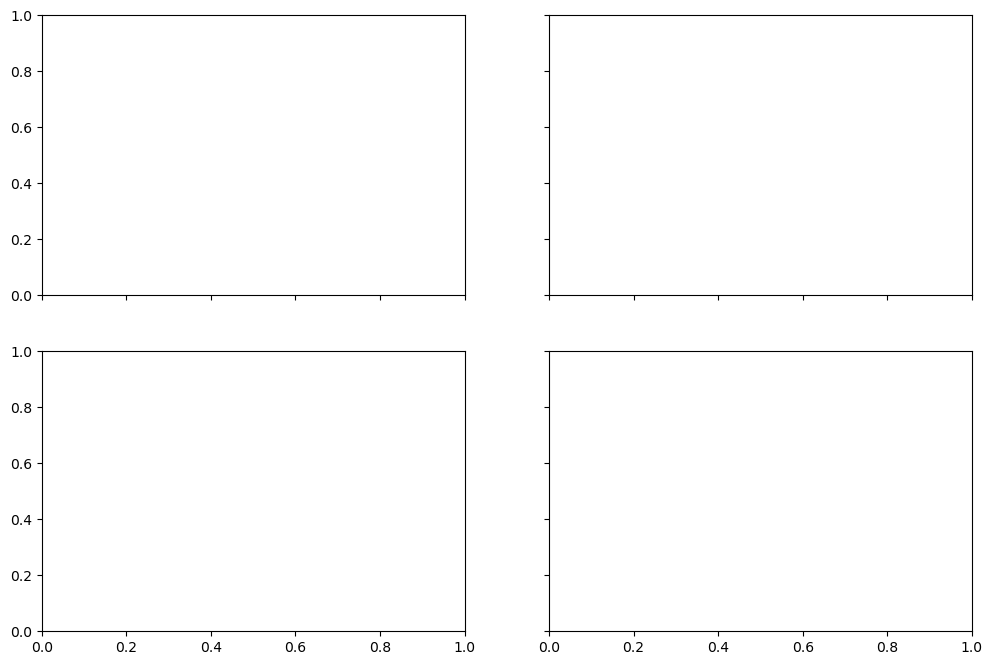

In [ ]:
subject_to_plot = 'K'  # 'K' or 'D'
subject_df = all_neurons_df[all_neurons_df['subject'] == subject_to_plot].copy()

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
bin_width = 100

for i, brain_area in enumerate([1, 0]):  # OFC (left), CdN (right)
    for j, correlation2plot in enumerate([1, -1]):  # Positive (top), Negative (bottom)

        # Filter neurons
        mask = (
            (subject_df['coding_type'] != 'none') &
            (subject_df['brain_area'] == brain_area)
        )
        neurons2plot = subject_df[mask].copy()

        # Select target depth
        target_depth = neurons2plot[neurons2plot['value_correlation'] == 1]['depth'].median()
        neurons2plot['rel_depth'] = neurons2plot['depth'] - target_depth

        # Bin depth
        min_depth = neurons2plot['rel_depth'].min()
        max_depth = neurons2plot['rel_depth'].max()
        depth_bins = np.arange(
            np.floor(min_depth / bin_width) * bin_width,
            np.ceil(max_depth / bin_width) * bin_width + bin_width,
            bin_width
        )
        neurons2plot['depth_bin'] = pd.cut(neurons2plot['rel_depth'], bins=depth_bins)

        # Compute probability
        prob_by_bin = neurons2plot.groupby('depth_bin')['value_correlation'].apply(
            lambda x: (x == correlation2plot).mean()
        )
        bin_centers = [interval.mid for interval in prob_by_bin.index]

        # Plot
        ax = axes[j, i]
        color = {1: 'red', -1: 'blue'}[correlation2plot]
        sns.scatterplot(x=bin_centers, y=prob_by_bin.values, color=color, ax=ax)
        sns.lineplot(x=bin_centers, y=prob_by_bin.values, color=color, ax=ax)

        # Labels
        area_label = {0: 'CdN', 1: 'OFC'}[brain_area]
        corr_label = {-1: 'Negative', 1: 'Positive'}[correlation2plot]
        ax.set_title(f'{area_label} - {corr_label} neurons ({subject_to_plot})')
        ax.axhline(0.5, color='gray', linestyle='--', linewidth=1)
        ax.set_xlabel('Relative depth')
        ax.set_ylabel('Prob of tuning')

plt.tight_layout()
plt.show()


In [ ]:
all_neurons_df

,session,subject,neuron,brain_area,lateral,depth,const_beta,value_beta,state_1_beta,state_2_beta,...,value_pval,state_1_pval,state_2_pval,state_3_pval,state_value_1_pval,state_value_2_pval,state_value_3_pval,coding_type,rel_depth,depth_bin
0,D20231219_Rec05,D,b'D20231219_Rec05_OFC_u2',1,88.272680,-5.395501,0.064782,-0.021819,-0.103674,0.138792,...,3.600719e-03,0.024518,0.003853,0.531005,0.104626,0.005207,0.764355,state_value,-2064.329607,"(-2100.0, -2000.0]"
1,D20231219_Rec05,D,b'D20231219_Rec05_OFC_u3',1,8.351528,38.571753,0.080885,-0.027055,-0.018384,0.081307,...,6.994404e-04,0.707094,0.110515,0.721306,0.914651,0.041578,0.714750,value,-2020.362353,"(-2100.0, -2000.0]"
2,D20231219_Rec05,D,b'D20231219_Rec05_OFC_u6',1,109.002712,77.172002,0.192756,-0.064685,0.088334,0.139525,...,1.489773e-14,0.080672,0.008104,0.499541,0.027451,0.003667,0.343386,state_value,-1981.762104,"(-2000.0, -1900.0]"
3,D20231219_Rec05,D,b'D20231219_Rec05_OFC_u7',1,-14.246603,105.280740,0.021504,-0.007595,0.021290,0.081391,...,2.992623e-01,0.636566,0.082860,0.080409,0.407720,0.030775,0.016956,state_value,-1953.653366,"(-2000.0, -1900.0]"
4,D20231219_Rec05,D,b'D20231219_Rec05_OFC_u9',1,84.579478,104.039762,0.098393,-0.032212,0.094129,0.119543,...,2.358417e-03,0.147894,0.077438,0.085219,0.192633,0.014199,0.035454,value,-1954.894344,"(-2000.0, -1900.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,K20240715_Rec09,K,b'K20240715_Rec09_OFC_u783',1,89.039978,3686.291861,-0.024902,0.008740,0.042783,0.003037,...,3.651496e-01,0.515685,0.962468,0.199538,0.345096,0.673499,0.037569,state_value,1603.080729,"(1600.0, 1700.0]"
2016,K20240715_Rec09,K,b'K20240715_Rec09_OFC_u797',1,91.641267,3742.774593,-0.217161,0.063280,-0.366733,-0.058600,...,3.580765e-05,0.000437,0.565367,0.016927,0.000001,0.833619,0.002880,state_value,1659.563461,"(1600.0, 1700.0]"
2017,K20240715_Rec09,K,b'K20240715_Rec09_OFC_u803',1,112.748236,3806.694507,-0.028354,0.009924,0.093903,-0.017965,...,2.622088e-01,0.119958,0.761453,0.039249,0.197691,0.600916,0.124344,state,1723.483375,"(1700.0, 1800.0]"
2018,K20240715_Rec09,K,b'K20240715_Rec09_OFC_u805',1,91.710207,3790.169095,0.101798,-0.032595,-0.093439,-0.049398,...,5.365037e-04,0.144571,0.431340,0.000006,0.127659,0.622423,0.000019,state_value,1706.957963,"(1700.0, 1800.0]"
